In [1]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17566480823429616138
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10063183872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10458062540444282023
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import os
import shutil
import random

# 현재 작업 디렉토리 가져오기
current_dir = os.getcwd()

model_number = 8
dataset_path = '../Dog_face_net_cropped_images'

# 데이터셋 경로 설정
base_dir = os.path.join(current_dir, dataset_path)
model_dir = os.path.join(current_dir, 'model_'+ str(model_number))
train_dir = os.path.join(model_dir, 'train')
validation_dir = os.path.join(model_dir, 'validation')

os.makedirs(model_dir, exist_ok=True)

# 폴더 비우기 함수 정의
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

# 폴더 초기화
clear_directory(train_dir)
clear_directory(validation_dir)

# 폴더명을 통해 전체 클래스 리스트 가져오기
all_classes = sorted(os.listdir(base_dir))

# 원하는 수의 클래스 선택 (예: 10개, 20개)
num_classes = 100  # 또는 10으로 변경 가능
selected_classes = all_classes[:num_classes]

# 각 클래스당 사용할 이미지 수
default_num_images_per_class = 100

# 각 클래스당 사용할 학습:검증의 비율
train_valid_rate = 0.8

for class_name in selected_classes:
    class_dir = os.path.join(base_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(validation_dir, class_name)
    
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    
    images = os.listdir(class_dir)
    num_images_per_class = min(default_num_images_per_class, len(images))
    random.shuffle(images)
    
    train_split = int(train_valid_rate * num_images_per_class)
    
    train_images = images[:train_split]
    val_images = images[train_split:num_images_per_class]
    
    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_class_dir, image)
        shutil.copyfile(src, dst)
    
    for image in val_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(val_class_dir, image)
        shutil.copyfile(src, dst)


In [3]:
selected_classes

['0',
 '1',
 '100',
 '1000',
 '1001',
 '1002',
 '1003',
 '1004',
 '1005',
 '1006',
 '1007',
 '1008',
 '1009',
 '101',
 '1010',
 '1011',
 '1012',
 '1013',
 '1014',
 '1015',
 '1016',
 '1017',
 '1018',
 '1019',
 '102',
 '1020',
 '1021',
 '1022',
 '1023',
 '1024',
 '1025',
 '1026',
 '1027',
 '1028',
 '1029',
 '103',
 '1030',
 '1031',
 '1032',
 '1033',
 '1034',
 '1035',
 '1036',
 '1037',
 '1038',
 '1039',
 '104',
 '1040',
 '1041',
 '1042',
 '1043',
 '1044',
 '1045',
 '1046',
 '1047',
 '1048',
 '1049',
 '105',
 '1050',
 '1051',
 '1052',
 '1053',
 '1054',
 '1055',
 '1056',
 '1057',
 '1058',
 '1059',
 '106',
 '1060',
 '1061',
 '1062',
 '1063',
 '1064',
 '1065',
 '1066',
 '1067',
 '1068',
 '1069',
 '107',
 '1070',
 '1071',
 '1072',
 '1073',
 '1074',
 '1075',
 '1076',
 '1077',
 '1078',
 '1079',
 '108',
 '1080',
 '1081',
 '1082',
 '1083',
 '1084',
 '1085',
 '1086',
 '1087',
 '1088']

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강 설정
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    classes=selected_classes,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=16,
    classes=selected_classes,
    class_mode='categorical')

Found 350 images belonging to 100 classes.
Found 125 images belonging to 100 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# ResNet 모델 불러오기 모델 불러오기
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

29084464/29084464 [==============================] - 1s 0us/step


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
21/21 [==============================] - 18s 290ms/step - loss: 4.9645 - accuracy: 0.0329 - val_loss: 22.3860 - val_accuracy: 0.0089
Epoch 2/50
21/21 [==============================] - 4s 196ms/step - loss: 3.8490 - accuracy: 0.1407 - val_loss: 70.6353 - val_accuracy: 0.0179
Epoch 3/50
21/21 [==============================] - 4s 197ms/step - loss: 2.9766 - accuracy: 0.2395 - val_loss: 6.0843 - val_accuracy: 0.0714
Epoch 4/50
21/21 [==============================] - 4s 191ms/step - loss: 2.4666 - accuracy: 0.3413 - val_loss: 10.8023 - val_accuracy: 0.0268
Epoch 5/50
21/21 [==============================] - 4s 193ms/step - loss: 2.0012 - accuracy: 0.4760 - val_loss: 7.1888 - val_accuracy: 0.0446
Epoch 6/50
21/21 [==============================] - 4s 191ms/step - loss: 1.8282 - accuracy: 0.4940 - val_loss: 6.8135 - val_accuracy: 0.0982
Epoch 7/50
21/21 [==============================] - 4s 194ms/step - loss: 1.4445 - accuracy: 0.6108 - val_loss: 12.1327 - val_accuracy: 0.0536
E

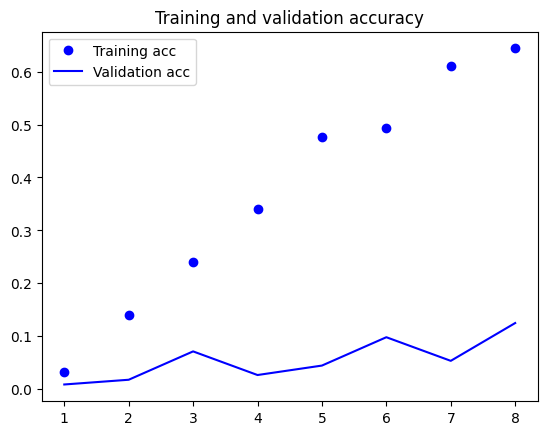

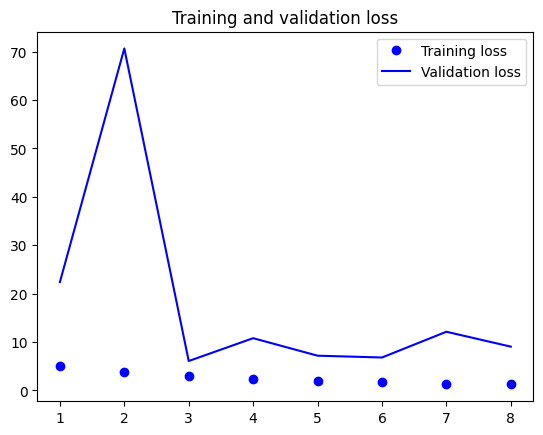

In [7]:
import matplotlib.pyplot as plt

def drawAccuracyGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

drawAccuracyGraph(history)

In [8]:
epochs = len(history.history['accuracy'])
last_acc = history.history['accuracy'][-1]
last_val_acc = history.history['val_accuracy'][-1]


In [9]:
base_model.name

'densenet121'

In [10]:
epochs = len(history.history['accuracy'])
last_acc = history.history['accuracy'][-1]
last_val_acc = history.history['val_accuracy'][-1]

log_text_path = "test_result.md"

with open(log_text_path, "a") as f:
    data = f"""# {'model_'+str(model_number)}\n
* 학습 데이터: {dataset_path}
* 개체수: {len(selected_classes)}
* 학습 모델: {base_model.name}
* 데이터 분할 비율: {round(train_valid_rate*10)}:{round((1-train_valid_rate)*10)}
* 배치 사이즈: {train_generator.batch_size}
* 반복 횟수: {epochs}
* 훈련 정확도: {last_acc}
* 검증 정확도: {last_val_acc}
    """
    f.write(data + "\n")